In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import mesa
import numpy as np
import pandas as pd
import random
from string import ascii_uppercase
from random import choice

# Original functions
def create_word(min_length=6, max_length=10):
    """Create a random word of a given length."""
    new_word = ''.join(choice(ascii_uppercase) for _ in range(np.random.randint(min_length, max_length)))
    return new_word

class SuccessRate(list):
    """Class for computing success rate with rolling window."""
    def __init__(self, maxlen=10):
        super().__init__()
        self._maxlen = maxlen

    def add(self, value):
        if type(value) != int:
            raise TypeError("Only integers are allowed in SuccessRate")
        if len(self) >= self._maxlen:
            self.pop(0)
        self.append(value)

    def get_rate(self):
        return sum(self)/len(self) if self else 0

    def get_values(self):
        return list(self)

In [3]:
class MiscommunicationAgent(mesa.Agent):
    """
    Extended agent class with various miscommunication mechanisms.

    This duplicates the original NamingGameAgent with additional miscommunication
    capabilities to study how communication errors affect vocabulary convergence.
    """

    def __init__(self, model, m_objects=1, miscommunication_type="none", miscommunication_params=None):
        """
        Create a new MiscommunicationAgent with various miscommunication mechanisms.

        Args:
            model: The model this agent belongs to.
            m_objects: The number of objects the agent can have a name in its vocabulary for.
            miscommunication_type: Type of miscommunication to apply ("none", "noise", "selective", "memory_decay", etc.)
            miscommunication_params: Dictionary of parameters for the miscommunication mechanism.
        """
        super().__init__(model)
        self._m_objects = m_objects
        self.vocabulary = dict()
        self.miscommunication_type = miscommunication_type
        self.miscommunication_params = miscommunication_params or {}

        self._init_miscommunication_attributes()

    def _init_miscommunication_attributes(self):
        """Initialize attributes specific to miscommunication types."""
        if self.miscommunication_type == "memory_decay":
            self.word_ages = {}
            self.memory_decay_rate = self.miscommunication_params.get("decay_rate", 0.01)
        elif self.miscommunication_type == "cognitive_load":
            self.max_vocabulary_size = self.miscommunication_params.get("max_size", 50)
        elif self.miscommunication_type == "cultural_barriers":
            self.cultural_group = self.miscommunication_params.get("cultural_group", 0)
            self.cultural_preference = self.miscommunication_params.get("cultural_preference", 0.5)

    def choose_object_and_word(self):
        """
        Choose a random object and word from its vocabulary.
        If no word is found for the object, create a new word.
        """
        chosen_object = np.random.randint(0, self._m_objects)

        if chosen_object in self.vocabulary.keys():
            chosen_word = random.choice(self.vocabulary[chosen_object])
        else:
            chosen_word = create_word()
            self.vocabulary[chosen_object] = [chosen_word]

        chosen_word = self._apply_outgoing_miscommunication(chosen_word)
        return chosen_object, chosen_word

    def recognize_word(self, chosen_object, chosen_word):
        """
        Check if the chosen word is in the vocabulary of the agent for the chosen object.
        """
        received_word = self._apply_incoming_miscommunication(chosen_word)

        if received_word is None:
            return False

        if chosen_object not in self.vocabulary.keys():
            return False
        if received_word in self.vocabulary[chosen_object]:
            return True
        else:
            return False

    def agree_to_word(self, chosen_object, chosen_word):
        """
        Reduces the number of words in the vocabulary for the chosen object to the agreed word.
        """
        agreed_word = self._apply_agreement_miscommunication(chosen_word)
        self.vocabulary[chosen_object] = [agreed_word]

        self._update_miscommunication_tracking(chosen_object, agreed_word)

    def add_word(self, chosen_object, chosen_word):
        """
        Add a new word to the vocabulary for the chosen object.
        """
        new_word = self._apply_learning_miscommunication(chosen_word)

        if self.miscommunication_type == "cognitive_load":
            if self.word_amount() >= self.max_vocabulary_size:
                self._remove_oldest_word()

        if chosen_object not in self.vocabulary.keys():
            self.vocabulary[chosen_object] = [new_word]
        else:
            self.vocabulary[chosen_object].append(new_word)

        self._update_miscommunication_tracking(chosen_object, new_word)

    def _apply_outgoing_miscommunication(self, word):
        """Apply miscommunication to outgoing words."""
        if self.miscommunication_type == "noise":
            return self._add_noise_to_word(word)
        elif self.miscommunication_type == "cultural_barriers":
            return self._apply_cultural_filter_outgoing(word)
        return word

    def _apply_incoming_miscommunication(self, word):
        """Apply miscommunication to incoming words."""
        if self.miscommunication_type == "selective":
            if random.random() < self.miscommunication_params.get("ignore_probability", 0.1):
                return None
        elif self.miscommunication_type == "partial_understanding":
            return self._apply_partial_understanding(word)
        elif self.miscommunication_type == "cultural_barriers":
            return self._apply_cultural_filter_incoming(word)
        return word

    def _apply_agreement_miscommunication(self, word):
        """Apply miscommunication during agreement."""
        if self.miscommunication_type == "confirmation_bias":
            return self._apply_confirmation_bias(word)
        return word

    def _apply_learning_miscommunication(self, word):
        """Apply miscommunication during learning."""
        if self.miscommunication_type == "memory_decay":
            return self._apply_memory_decay_learning(word)
        return word

    def _add_noise_to_word(self, word):
        """Add noise to word transmission."""
        noise_probability = self.miscommunication_params.get("noise_probability", 0.05)
        if random.random() < noise_probability:
            # Randomly change one character
            if len(word) > 0:
                pos = random.randint(0, len(word) - 1)
                new_char = random.choice(ascii_uppercase)
                word = word[:pos] + new_char + word[pos+1:]
        return word

    def _apply_partial_understanding(self, word):
        """Apply partial understanding - only remember part of the word."""
        understanding_ratio = self.miscommunication_params.get("understanding_ratio", 0.7)
        if random.random() > understanding_ratio:
            # Remember only a portion of the word
            length = max(1, int(len(word) * understanding_ratio))
            start = random.randint(0, len(word) - length)
            word = word[start:start + length]
        return word

    def _apply_confirmation_bias(self, word):
        """Apply confirmation bias - prefer words similar to existing vocabulary."""
        bias_strength = self.miscommunication_params.get("bias_strength", 0.3)
        if random.random() < bias_strength:
            # Check if we have similar words in vocabulary
            for obj_words in self.vocabulary.values():
                for existing_word in obj_words:
                    if self._word_similarity(word, existing_word) > 0.5:
                        return existing_word
        return word

    def _apply_cultural_filter_outgoing(self, word):
        """Apply cultural filtering based on word length preference."""
        cultural_strength = self.miscommunication_params.get("cultural_strength", 0.2)
        if random.random() < cultural_strength:
            # Cultural preference for word length
            if self.cultural_preference > 0.5 and len(word) > 8:
                # Prefer shorter words - truncate
                word = word[:6]
            elif self.cultural_preference < 0.5 and len(word) < 8:
                # Prefer longer words - extend
                word = word + "XX"
        return word

    def _apply_cultural_filter_incoming(self, word):
        """Apply cultural filtering to incoming words."""
        cultural_strength = self.miscommunication_params.get("cultural_strength", 0.2)
        if random.random() < cultural_strength:
            # Simple length-based cultural preference
            if self.cultural_preference > 0.5 and len(word) > 8:
                return None  # This culture rejects long words
            elif self.cultural_preference < 0.5 and len(word) < 6:
                return None  # This culture rejects short words

        return word

    def _apply_memory_decay_learning(self, word):
        """Apply memory decay during learning."""
        # For now, just return the word - decay happens over time
        return word

    def _word_similarity(self, word1, word2):
        """Calculate similarity between two words."""
        # Simple character-based similarity
        common_chars = sum(1 for c in word1 if c in word2)
        return common_chars / max(len(word1), len(word2))

    def _remove_oldest_word(self):
        """Remove the oldest word from vocabulary when at cognitive load limit."""
        # Simple implementation: remove random word from random object
        if self.vocabulary:
            obj = random.choice(list(self.vocabulary.keys()))
            if self.vocabulary[obj]:
                self.vocabulary[obj].pop()
                if not self.vocabulary[obj]:
                    del self.vocabulary[obj]

    def _update_miscommunication_tracking(self, object_id, word):
        """Update tracking for miscommunication mechanisms."""
        if self.miscommunication_type == "memory_decay":
            if object_id not in self.word_ages:
                self.word_ages[object_id] = {}
            self.word_ages[object_id][word] = self.model.steps

    def apply_memory_decay(self):
        """Apply memory decay over time."""
        if self.miscommunication_type == "memory_decay":
            current_time = self.model.steps
            for obj_id, words in list(self.vocabulary.items()):
                if len(words) > 1:
                    for word in list(words):
                        if word in self.word_ages.get(obj_id, {}):
                            age = current_time - self.word_ages[obj_id][word]
                            decay_prob = min(0.1, age * self.memory_decay_rate)
                            if random.random() < decay_prob:
                                words.remove(word)
                                del self.word_ages[obj_id][word]
                if not words:
                    del self.vocabulary[obj_id]
                    if obj_id in self.word_ages:
                        del self.word_ages[obj_id]

    def retrieve_vocabulary(self):
        """Create a string representation of the vocabulary."""
        return [f"Object: {key} - words: {value}" for key, value in self.vocabulary.items()]

    def word_amount(self):
        """Calculate the number of words in the vocabulary."""
        return int(sum([len(word_list) for word_list in self.vocabulary.values()]))

    #@classmethod
    #def create_agents(cls, model, n, m_objects=1, miscommunication_type="none", miscommunication_params=None):
    #    """Create n agents and add them to the model."""
    #    for i in range(n):
    #        agent = cls(model, m_objects, miscommunication_type, miscommunication_params)
    #        model.agents.append(agent)
    #        model.schedule.add(agent)

In [4]:
class MiscommunicationModel(mesa.Model):
    """
    Extended model class with miscommunication capabilities.

    This duplicates the original NamingGameModel with additional miscommunication
    tracking and mechanisms to study their effects on vocabulary convergence.
    """

    def __init__(self, N=100, m_objects=1, seed=None, data_resolution=100, detailed_info=True,
                 miscommunication_type="none", miscommunication_params=None):
        """
        Create a new MiscommunicationModel.

        Args:
            N: The number of agents in the model.
            m_objects: The number of objects the agents can have a name in its vocabulary for.
            seed: The random seed for the model.
            data_resolution: The resolution of the data collection.
            detailed_info: If True, collect detailed information about the agents.
            miscommunication_type: Type of miscommunication to apply to all agents.
            miscommunication_params: Parameters for the miscommunication mechanism.
        """
        super().__init__(seed=seed)
        self._detailed_info = detailed_info
        self._data_resolution = data_resolution
        self.max_words = 0
        self.max_time = 0
        self.conv_time = -1
        self.num_agents = N
        self.success_rate = SuccessRate(maxlen=1000)
        self.miscommunication_type = miscommunication_type
        self.miscommunication_params = miscommunication_params or {}
        self.message_queue = {}

        # Initialize data collectors
        self.agent_datacollector = mesa.DataCollector(
            agent_reporters={"Word_amount": MiscommunicationAgent.word_amount}
        )
        self.datacollector = mesa.DataCollector(
            model_reporters={"Success_rate": self.success_rate.get_rate,
                             "Total_word_amount": "total_word_amount",
                             "Total_unique_word_amount": "total_unique_word_amount",
                             "Miscommunication_events": "miscommunication_events"}
        )

        self.m_objects = m_objects
        self.miscommunication_events = 0

        # Create agents with miscommunication
        MiscommunicationAgent.create_agents(
            model=self,
            n=N,
            m_objects=m_objects,
            miscommunication_type=miscommunication_type,
            miscommunication_params=miscommunication_params
        )

    def update_max_words(self):
        if self.max_words < self.total_word_amount:
            self.max_words = self.total_word_amount
            self.max_time = self.steps

    def check_convergence(self):
        """Check if the model has converged and remember the time of convergence."""
        if self.total_unique_word_amount == self.m_objects and self.conv_time == -1:
            self.conv_time = self.steps

    def step(self):
        # Apply time-based miscommunication effects
        self._apply_time_based_miscommunication()

        if self.steps % self._data_resolution == 0:
            self.datacollector.collect(self)
            self.update_max_words()
            self.check_convergence()
        if self.steps % self._data_resolution == 0 and self._detailed_info:
            self.agent_datacollector.collect(self)

        speaker, hearer = random.sample(self.agents, 2)
        self.message_queue[(speaker, hearer)] = self.miscommunication_params.get("delay_steps", 1)

        # dict init is needed to avoid RuntimeError: dictionary changed size during iteration
        for message_agents in dict(self.message_queue).keys():
            speaker, hearer = message_agents
            chosen_object, chosen_word = speaker.choose_object_and_word()

            # Handle communication delays
            if self.miscommunication_type == "communication_delays":
                self._handle_communication_delay(speaker, hearer, chosen_object, chosen_word)
            else:
                self._handle_immediate_communication(speaker, hearer, chosen_object, chosen_word)

    def _apply_time_based_miscommunication(self):
        """Apply time-based miscommunication effects."""
        if self.miscommunication_type == "memory_decay":
            for agent in self.agents:
                agent.apply_memory_decay()  # type: ignore[attr-defined]

    def _handle_immediate_communication(self, speaker, hearer, chosen_object, chosen_word):
        """Handle immediate communication between agents."""
        self.message_queue.pop((speaker, hearer))
        if hearer.recognize_word(chosen_object, chosen_word):
            self.success_rate.add(1)
            speaker.agree_to_word(chosen_object, chosen_word)
            hearer.agree_to_word(chosen_object, chosen_word)
        else:
            self.success_rate.add(0)
            hearer.add_word(chosen_object, chosen_word)
            self.miscommunication_events += 1

    def _handle_communication_delay(self, speaker, hearer, chosen_object, chosen_word):
        """Handle communication with delays."""
        delay_steps = self.message_queue[(speaker, hearer)]
        if delay_steps <= 0:
            self._handle_immediate_communication(speaker, hearer, chosen_object, chosen_word)
            return
        delay_steps -= 1
        self.message_queue[(speaker, hearer)] = delay_steps

    @property
    def total_word_amount(self):
        """Calculate the total number of words in the vocabulary of all agents."""
        return sum([agent.word_amount() for agent in self.agents])  # type: ignore[attr-defined]

    @property
    def total_unique_word_amount(self):
        """Calculate the total number of unique words in the vocabulary of all agents."""
        unique_words = set()
        for agent in self.agents:
            for word_list in agent.vocabulary.values():  # type: ignore[attr-defined]
                unique_words.update(word_list)
        return len(unique_words)

In [5]:
def run_miscommunication_model(N, M, t, iteration, miscommunication_type="none",
                              miscommunication_params=None, data_resolution=100):
    """
    Run a model with specified miscommunication type and parameters.
    """
    print(f"Starting miscommunication model iteration: {iteration} with type: {miscommunication_type}")
    model = MiscommunicationModel(N, M, data_resolution=data_resolution,
                                  miscommunication_type=miscommunication_type,
                                  miscommunication_params=miscommunication_params)

    for i in range(t):
        model.step()

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.agent_datacollector.get_agent_vars_dataframe()
    return model_data, agent_data, model.miscommunication_events, model.conv_time

In [6]:
def compare_miscommunication_types(N=100, M=1, t=10000, runs=10):
    """
    Compare different types of miscommunication and their effects on convergence.
    """
    miscommunication_configs = {
        "baseline": {"type": "none", "params": {}},
        "noise": {"type": "noise", "params": {"noise_probability": 0.1}},
        "selective_hearing": {"type": "selective", "params": {"ignore_probability": 0.2}},
        "memory_decay": {"type": "memory_decay", "params": {"decay_rate": 0.001}},
        "confirmation_bias": {"type": "confirmation_bias", "params": {"bias_strength": 0.3}},
        "cognitive_load": {"type": "cognitive_load", "params": {"max_size": 20}},
        "partial_understanding": {"type": "partial_understanding", "params": {"understanding_ratio": 0.6}},
        "cultural_barriers": {"type": "cultural_barriers", "params": {"cultural_strength": 0.4}}
    }

    results = {}

    for config_name, config in miscommunication_configs.items():
        print(f"\nTesting {config_name}...")
        config_results = []

        for run in range(runs):
            model_data, agent_data, miscommunication_events, conv_time = run_miscommunication_model(
                N=N, M=M, t=t, iteration=run + 1,
                miscommunication_type=config["type"],
                miscommunication_params=config["params"]
            )

            final_success_rate = model_data["Success_rate"].iloc[-1]
            final_unique_words = model_data["Total_unique_word_amount"].iloc[-1]

            config_results.append({
                "success_rate": final_success_rate,
                "unique_words": final_unique_words,
                "convergence_time": conv_time,
                "miscommunication_events": miscommunication_events
            })

        conv_times = [r["convergence_time"] for r in config_results if r["convergence_time"] > 0]
        avg_conv_time = np.mean(conv_times) if conv_times else -1
        avg_success = np.mean([r["success_rate"] for r in config_results])
        avg_unique = np.mean([r["unique_words"] for r in config_results])
        avg_miscomm_events = np.mean([r["miscommunication_events"] for r in config_results])

        results[config_name] = {
            "avg_success_rate": avg_success,
            "avg_unique_words": avg_unique,
            "avg_convergence_time": avg_conv_time,
            "avg_miscommunication_events": avg_miscomm_events,
            "runs": config_results
        }

    return results


In [7]:
def visualize_miscommunication_comparison(results):
    """
    Create visualizations comparing different miscommunication types.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    config_names = list(results.keys())
    success_rates = [results[name]["avg_success_rate"] for name in config_names]
    unique_words = [results[name]["avg_unique_words"] for name in config_names]
    conv_times = [results[name]["avg_convergence_time"] for name in config_names]
    miscomm_events = [results[name]["avg_miscommunication_events"] for name in config_names]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Success rates
    axs[0, 0].bar(config_names, success_rates, color='skyblue')
    axs[0, 0].set_title('Average Success Rate by Miscommunication Type')
    axs[0, 0].set_ylabel('Success Rate')
    axs[0, 0].tick_params(axis='x', rotation=45)

    # Unique words
    axs[0, 1].bar(config_names, unique_words, color='lightgreen')
    axs[0, 1].set_title('Average Unique Words by Miscommunication Type')
    axs[0, 1].set_ylabel('Unique Words')
    axs[0, 1].tick_params(axis='x', rotation=45)

    # Convergence times (only for converged runs)
    valid_conv_times = [(name, time) for name, time in zip(config_names, conv_times) if time > 0]
    if valid_conv_times:
        names, times = zip(*valid_conv_times)
        axs[1, 0].bar(names, times, color='orange')
        axs[1, 0].set_title('Average Convergence Time (Converged Runs Only)')
        axs[1, 0].set_ylabel('Time Steps')
        axs[1, 0].tick_params(axis='x', rotation=45)

    # Miscommunication events
    axs[1, 1].bar(config_names, miscomm_events, color='red')
    axs[1, 1].set_title('Average Miscommunication Events')
    axs[1, 1].set_ylabel('Events')
    axs[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return fig

Miscommunication Framework for Agent-to-Agent Communication

Running quick comparison of miscommunication types...

Testing baseline...
Starting miscommunication model iteration: 1 with type: none
Starting miscommunication model iteration: 2 with type: none
Starting miscommunication model iteration: 3 with type: none
Starting miscommunication model iteration: 4 with type: none
Starting miscommunication model iteration: 5 with type: none

Testing noise...
Starting miscommunication model iteration: 1 with type: noise
Starting miscommunication model iteration: 2 with type: noise
Starting miscommunication model iteration: 3 with type: noise
Starting miscommunication model iteration: 4 with type: noise
Starting miscommunication model iteration: 5 with type: noise

Testing selective_hearing...
Starting miscommunication model iteration: 1 with type: selective
Starting miscommunication model iteration: 2 with type: selective
Starting miscommunication model iteration: 3 with type: selective
Sta

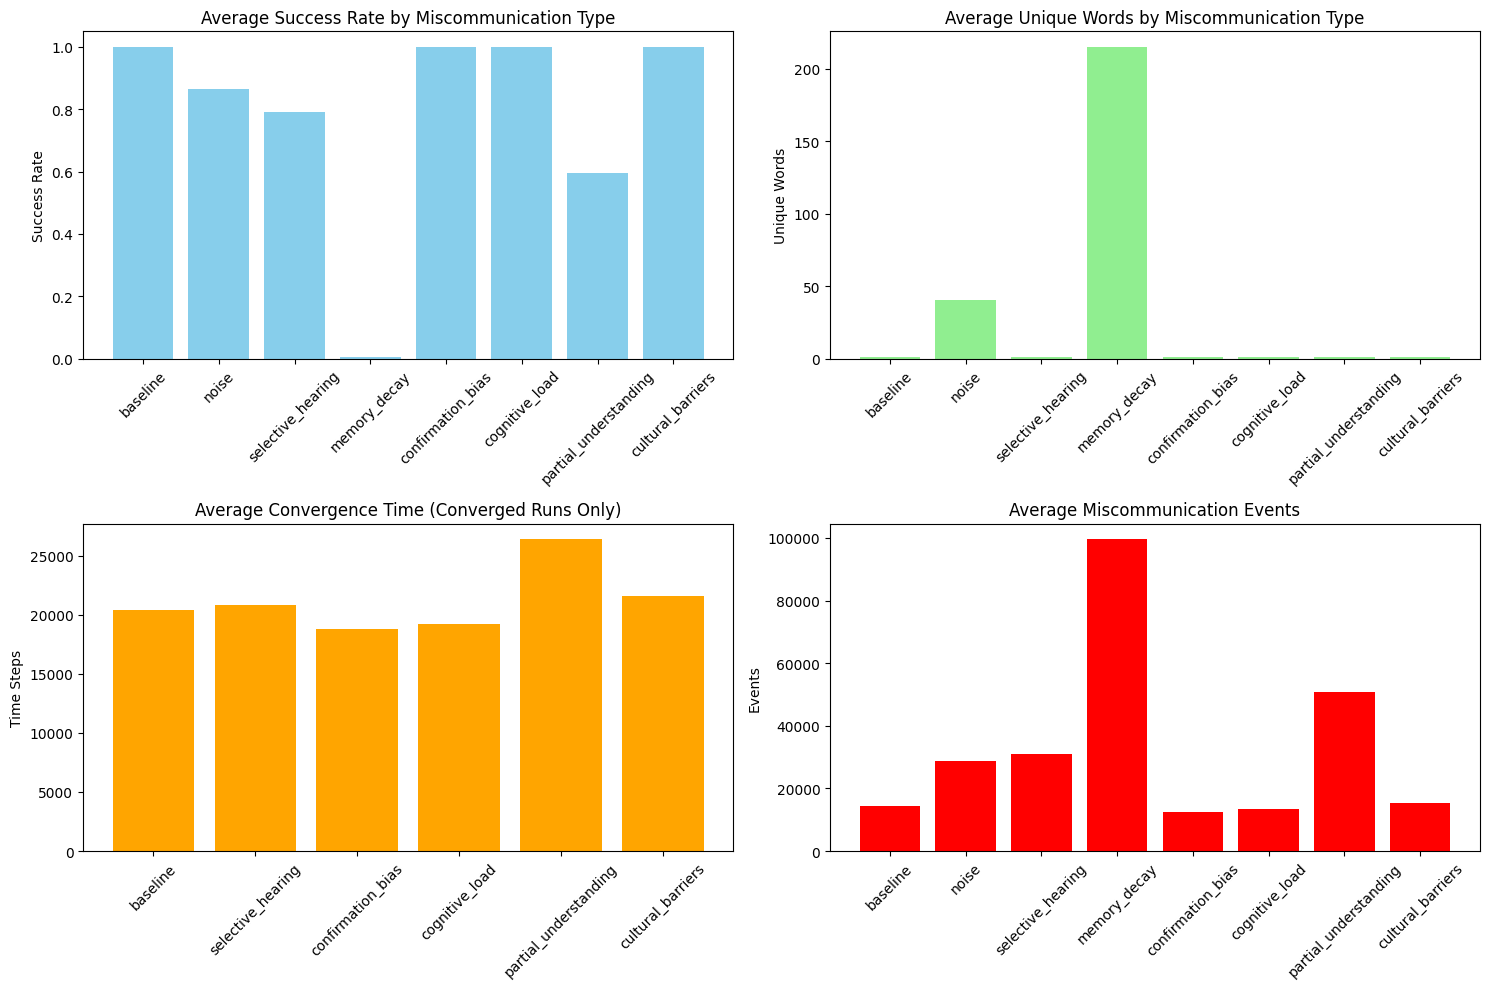

Done!


In [8]:
print("Miscommunication Framework for Agent-to-Agent Communication")
print("=" * 60)

# Quick experiment with smaller parameters for demonstration
print("\nRunning quick comparison of miscommunication types...")
#results = compare_miscommunication_types(N=50, M=1, t=5000, runs=3)
results = compare_miscommunication_types(N=500, M=1, t=100000, runs=10)

print("\nResults Summary:")
for config_name, result in results.items():
    print(f"{config_name}: Success Rate = {result['avg_success_rate']:.3f}, "
            f"Unique Words = {result['avg_unique_words']:.1f}")

# Visualize results
visualize_miscommunication_comparison(results)
print("Done!")